In [1]:
# import libraries
import xarray as xr
import fsspec
import numpy as np
import s3fs
import zarr
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import geopandas as gpd
import contextily as ctx
from shapely.geometry import Point
import datetime
from watermark import watermark

In [33]:
def analyze_aorc_amc_plots(lat, lon, thresholds_in,index_no, start_year=1979, end_year=2024):
    safe_lat = str(lat).replace('.', '_')
    safe_lon = str(lon).replace('.', '_')
    base_url = 's3://noaa-nws-aorc-v1-1-1km'
    var = 'APCP_surface'
    thresholds_mm = [t * 25.4 for t in thresholds_in]  # Convert to mm
    years = range(start_year, end_year + 1)

    all_ts = []
    for year in tqdm(years, desc="Loading years"):
        url = f"{base_url}/{year}.zarr/"
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
        precip_ts = ds[var].sel(latitude=lat, longitude=lon, method='nearest')
        all_ts.append(precip_ts.to_series())

    hourly_series = pd.concat(all_ts)
    # === Compute 5-day total ===
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    # === Plot 1: Full Hourly Time Series with Annual Maxima and Thresholds ===
    fig, ax = plt.subplots(figsize=(8, 4))

    # Primary y-axis: Hourly precipitation
    hourly_series.plot(ax=ax, label='Hourly Precipitation', color='skyblue', linewidth=1)

    # Secondary y-axis: 5-day antecedent rainfall
    ax2 = ax.twinx()
    antecedent_5day.plot.line(ax=ax2, label='120-hr Precipitation', color='black', linewidth=0.5, alpha=0.3, zorder=1)

    # Annual maxima
    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    annual_max_values = hourly_series.loc[annual_max_idx].dropna()
    annual_max_values = annual_max_values[annual_max_values.index.isin(hourly_series.index)]
    ax.scatter(
        annual_max_values.index,
        annual_max_values.values,
        marker='*',
        s=120,
        facecolors='white',
        edgecolors='red',
        linewidths=1.2,
        label='Annual Maxima',
        zorder=5
    )

    # Thresholds (2-year and 5-year)
    linestyles = ['--', '-.']
    threshold_labels = ['2-Year', '5-Year']
    for i, (t_mm, t_in) in enumerate(zip(thresholds_mm[:2], thresholds_in[:2])):
        ax.axhline(
            t_mm,
            color='red',
            linestyle=linestyles[i % len(linestyles)],
            linewidth=2,
            label=f'{threshold_labels[i]}'
        )

    # Shade dormant and growing seasons
    ts_min = hourly_series.index.min()
    ts_max = hourly_series.index.max()

    # Extend range to include the dormant season before the first data point
    for year in range(ts_min.year - 1, ts_max.year + 1):
        start_dormant = pd.Timestamp(f'{year}-11-01')
        end_dormant = pd.Timestamp(f'{year + 1}-04-30')
        if end_dormant >= ts_min and start_dormant <= ts_max:
            ax.axvspan(start_dormant, end_dormant,
                    color='lightgrey', alpha=0.3,
                    label='Dormant Season' if year == ts_min.year - 1 else "")

        start_growing = pd.Timestamp(f'{year + 1}-05-01')
        end_growing = pd.Timestamp(f'{year + 1}-10-31')
        if start_growing >= ts_min and end_growing <= ts_max:
            ax.axvspan(start_growing, end_growing,
                    color='lightgreen', alpha=0.15,
                    label='Growing Season' if year == ts_min.year else "")
    # Axis formatting
    ax.set_ylabel(f"1-hr precipitation ($mm$)")
    ax.set_ylim(bottom=0)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax2.set_ylabel(f"120-hr Precipitation ($mm$)")
    ax2.set_ylim(bottom=0)

    # Combine legends from both axes
    handles1, labels1 = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(
    handles1 + handles2,
    labels1 + labels2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.25),  # lower value = further below
    ncol=4,
    frameon=False
    )   
    plt.title(f"Sample point index: {index_no}", fontsize=13)
    plt.tight_layout()
    plt.savefig(fr"D:\culvert repo\Results\Figures\index_{index_no}_perc_timeseries.png", dpi=300, bbox_inches='tight')
    plt.show()

    # === Compute 5-day total ===
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    def classify_amc(ts, rain_5d):
        m = ts.month
        if pd.isna(rain_5d):
            return None
        if 5 <= m <= 10:
            if rain_5d < 1.4*25.4: return 'Dry'
            elif rain_5d <= 2.1*25.4: return 'Normal'
            else: return 'Wet'
        else:
            if rain_5d < 0.5*25.4: return 'Dry'
            elif rain_5d <= 1.1*25.4: return 'Normal'
            else: return 'Wet'

    amc = pd.Series(
        [classify_amc(ts, rain) for ts, rain in antecedent_5day.items()],
        index=antecedent_5day.index
    )

    df = pd.DataFrame({
        'hourly_rain_mm': hourly_series,
        'antecedent_5day_mm': antecedent_5day,
        'AMC': amc
    })

    
    # === Merged AMC Distributions on Same Axis ===
    plt.figure(figsize=(4, 3))
    bar_width = 0.2
    amc_order = ['Dry', 'Normal', 'Wet']

    # --- 0. Plot AMC for All Days ---
    offset = -1 * bar_width  # Shift left
    counts_all = df['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)
    plt.bar(
        [x + offset for x in range(len(amc_order))],
        counts_all.values,
        width=bar_width,
        label='All events',
        edgecolor='black',
        color='black'
    )
    # --- 1. Plot AMC at Annual Maxima ---
    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    amc_annual_max = df.loc[annual_max_idx, 'AMC']
    counts_annual = amc_annual_max.value_counts(normalize=True).reindex(amc_order).fillna(0)
    plt.bar(
        [x for x in range(len(amc_order))],
        counts_annual.values,
        width=bar_width,
        label='Annual maxima',
        edgecolor='black',
        color='gray'
    )

    # --- 2. Plot AMC for each threshold ---
    threshold_labels = ['>2-yr', '>5-yr']
    threshold_colors = ['lightblue', 'darkblue']  

    for i, (t_mm, t_in) in enumerate(zip(thresholds_mm, thresholds_in)):
        subset = df[df['hourly_rain_mm'] > t_mm]
        counts = subset['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)
        # Offset bar position to avoid overlap
        offset = (i + 1) * bar_width
        plt.bar(
            [x + offset for x in range(len(amc_order))],
            counts.values,
            width=bar_width,
            label=threshold_labels[i],
            color=threshold_colors[i],
            edgecolor='black'
        )

    # --- Formatting ---
    total_bars = len(thresholds_in) + 1
    midpoints = [x + bar_width * (total_bars - 1) / 2 for x in range(len(amc_order))]
    plt.xticks(midpoints, amc_order, fontsize=12)
    plt.ylabel("Probability", fontsize=12)
    plt.xlabel("Antecedent soil moisture state", fontsize=12)

    plt.title(f"Sample point index: {index_no}", fontsize=13)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.legend(
    ncol=2,
    loc='upper center',
    bbox_to_anchor=(0.5, -0.2),  # below the plot
    frameon=False
    )
    plt.tight_layout()
    plt.savefig(fr"D:\culvert repo\Results\Figures\index_{index_no}_AMC_state_prob.png", dpi=300, bbox_inches='tight')
    plt.show()
    df.to_excel(fr"D:\culvert repo\Results\AMC\index_{index_no}_hourly_data.xlsx")


# Samples

Loading years: 100%|██████████| 46/46 [00:38<00:00,  1.19it/s]


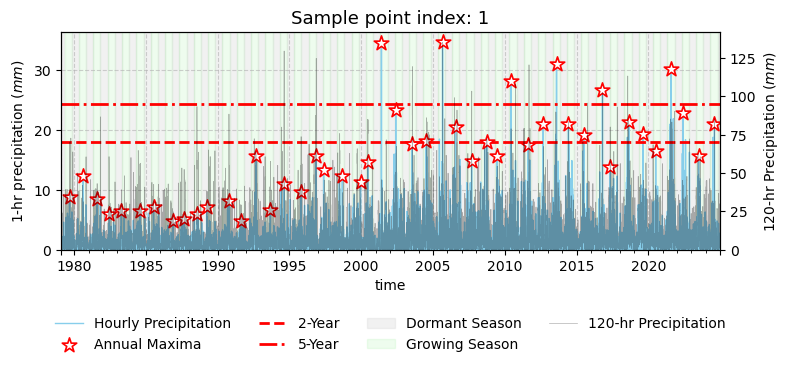

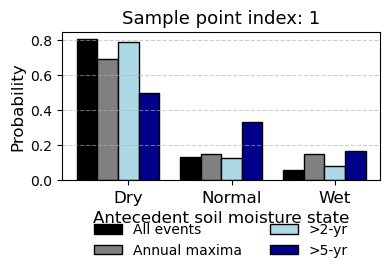

In [34]:
thresholds = [0.709, 0.960]  
lat_nys = 42.2
lon_nys = -77.14
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds, index_no=1)

Loading years: 100%|██████████| 46/46 [00:36<00:00,  1.25it/s]


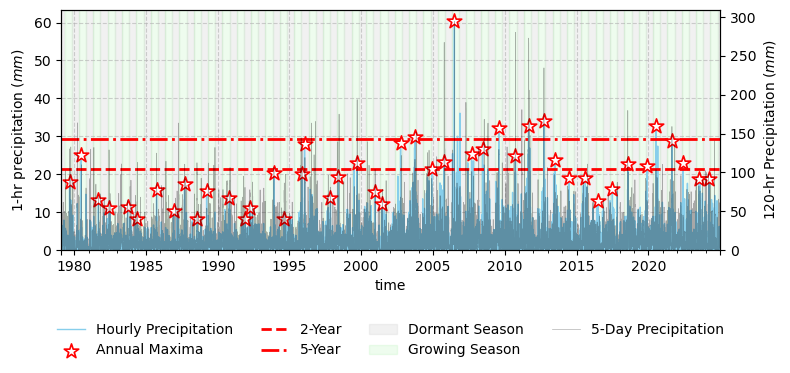

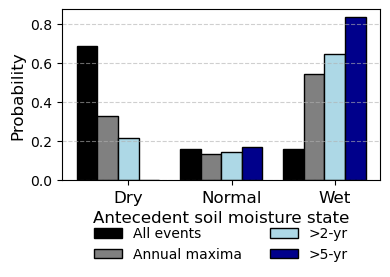

In [4]:
thresholds = [0.844, 1.15]  
lat_nys = 42.1445
lon_nys = -74.2952
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:38<00:00,  1.18it/s]


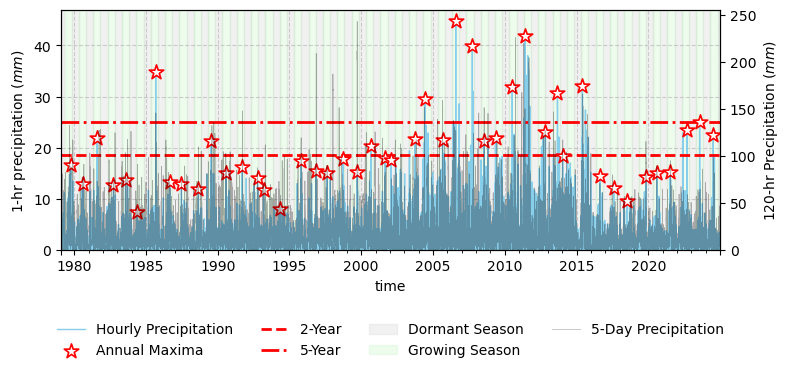

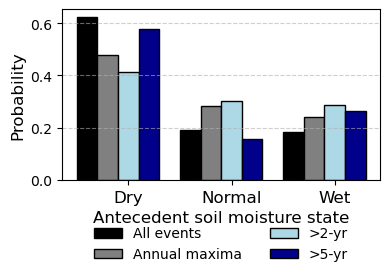

In [5]:
thresholds = [0.728, 0.988]  
lat_nys = 44.1009
lon_nys = -73.9436
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:34<00:00,  1.34it/s]


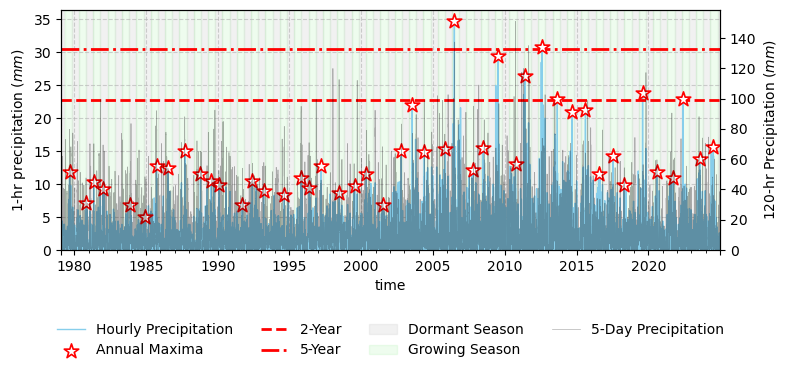

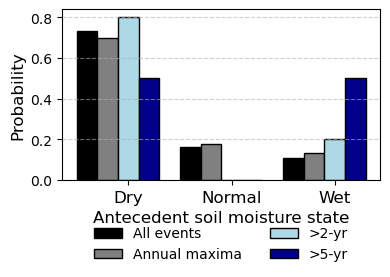

In [6]:
thresholds = [0.896, 1.20]  
lat_nys =  43.6392
lon_nys = -74.1414

analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:35<00:00,  1.30it/s]


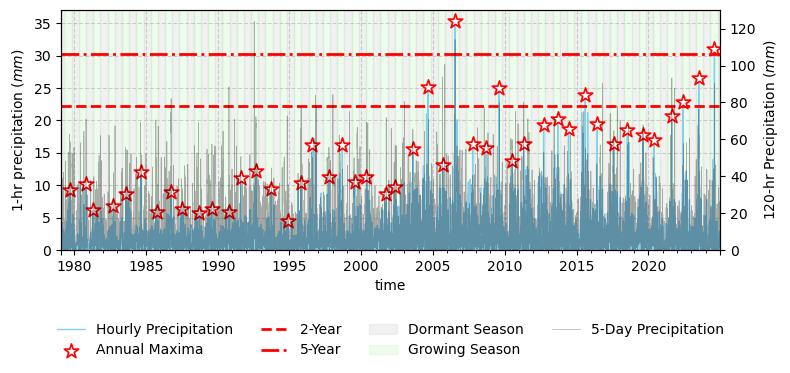

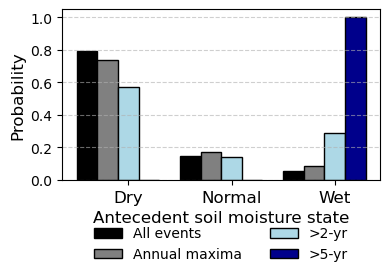

In [7]:
thresholds = [0.874, 1.19]  
lat_nys =  43.1145
lon_nys = -76.8989
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:37<00:00,  1.24it/s]


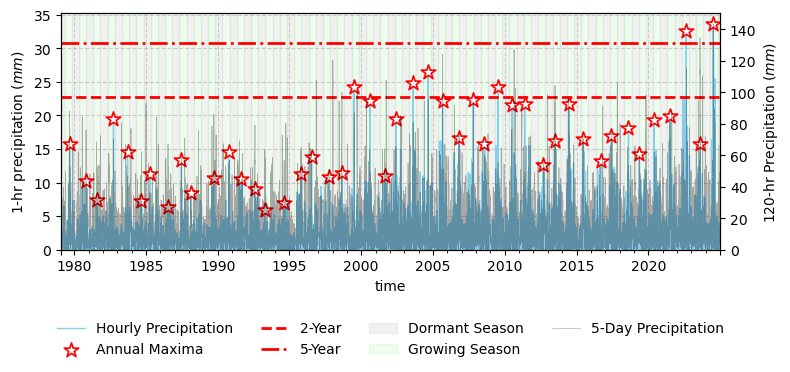

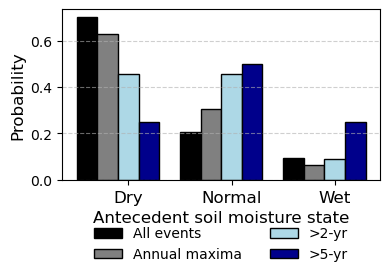

In [8]:
thresholds = [0.895, 1.21]  
lat_nys =  43.8241
lon_nys = -75.2400
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:35<00:00,  1.29it/s]


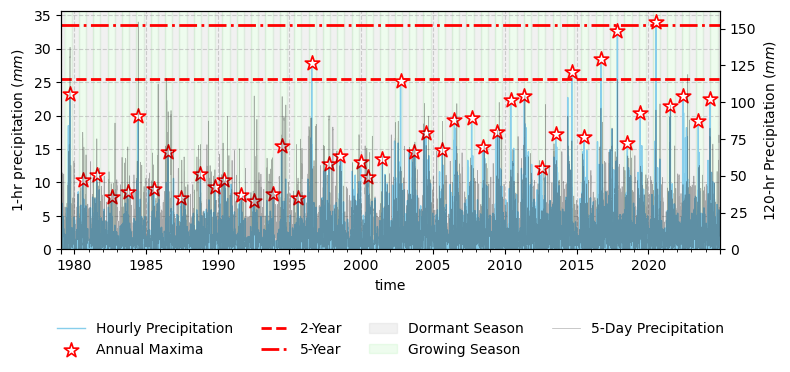

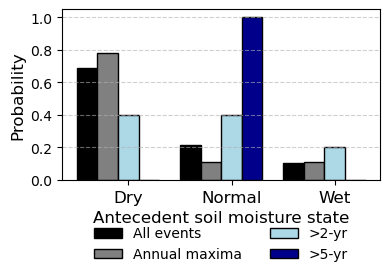

In [9]:
thresholds = [1.00, 1.32]
lat_nys =  42.2073
lon_nys = -79.3709
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:37<00:00,  1.22it/s]


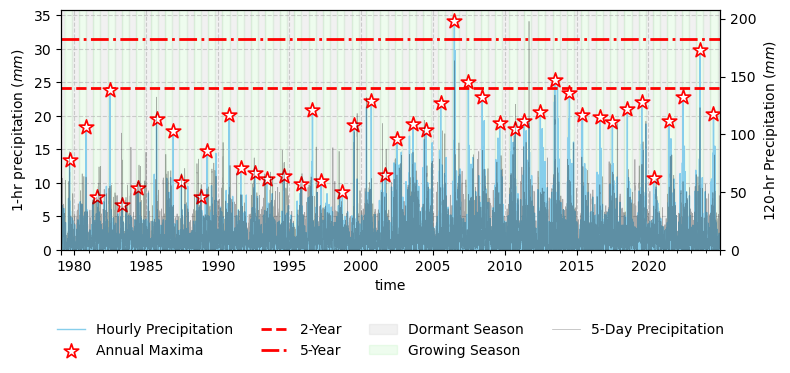

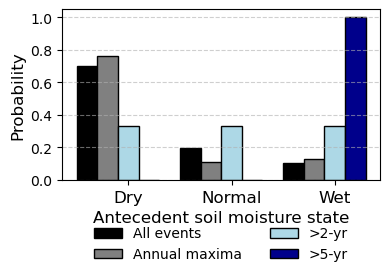

In [10]:
thresholds = [0.954, 1.24] 
lat_nys =  43.2060
lon_nys =   -75.2071
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:40<00:00,  1.15it/s]


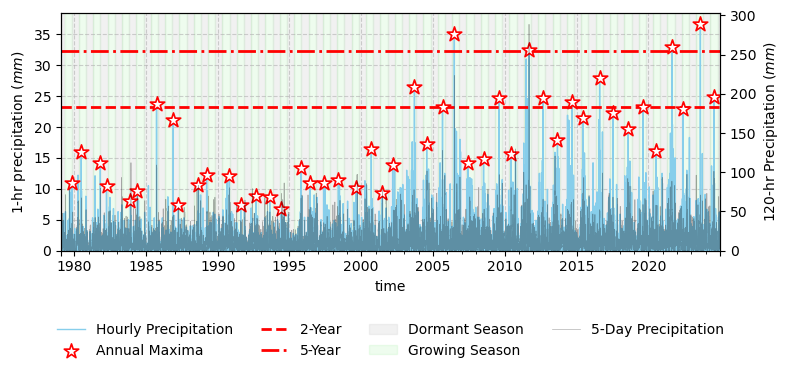

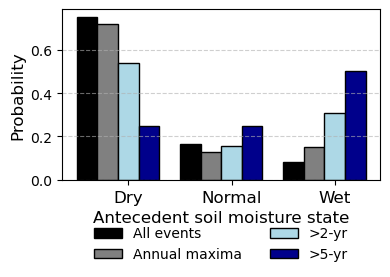

In [11]:
thresholds = [0.915, 1.27]  # in inches
lat_nys =  42.3269
lon_nys =   -75.8882
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


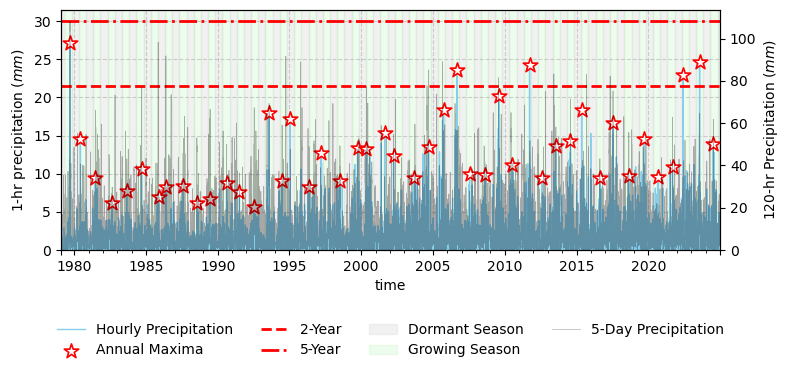

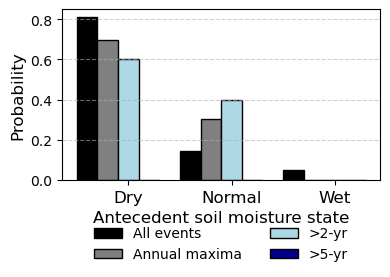

In [12]:
thresholds = [0.845, 1.18]  # in inches
lat_nys =  43.3340
lon_nys = -78.6677
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:34<00:00,  1.32it/s]


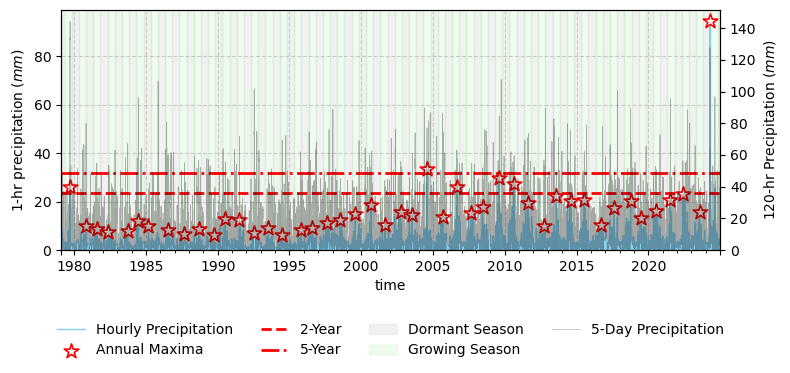

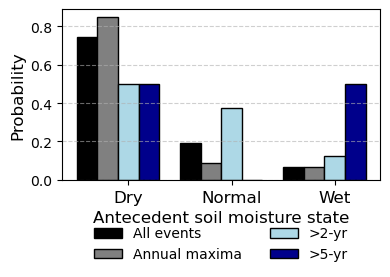

In [13]:
thresholds = [0.929, 1.25]  # in inches
lat_nys =  42.5297
lon_nys = -78.9864
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:34<00:00,  1.33it/s]


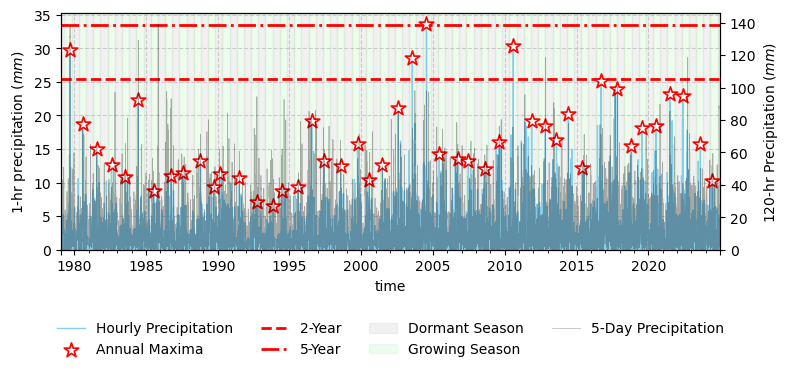

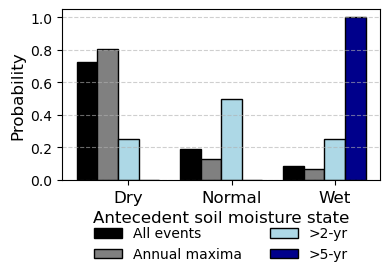

In [14]:
thresholds = [1.00, 1.32]  # in inches
lat_nys =  42.2701
lon_nys =   -79.7114
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:33<00:00,  1.36it/s]


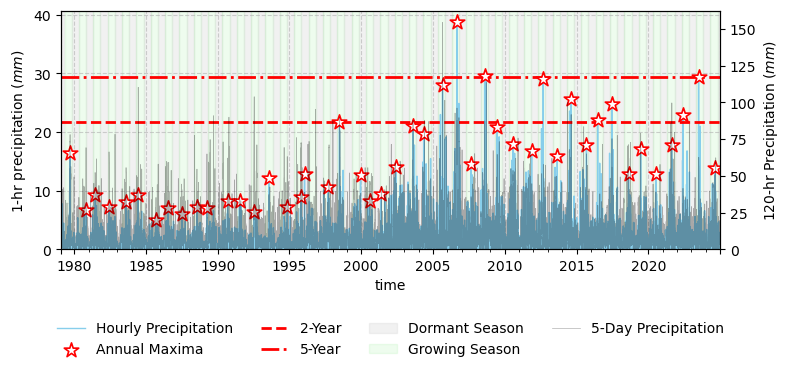

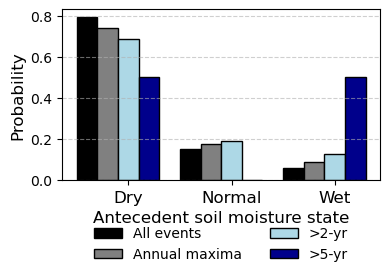

In [15]:
thresholds = [0.852, 1.16]  # in inches
lat_nys =  42.5701
lon_nys =  -78.0635
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:35<00:00,  1.28it/s]


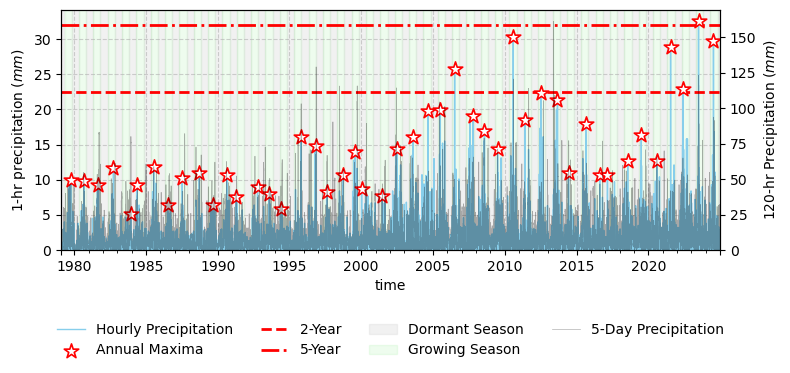

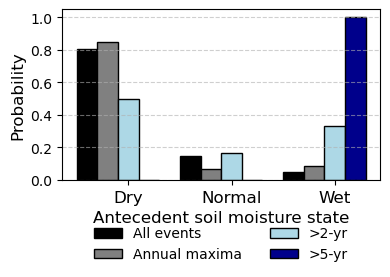

In [16]:
thresholds = [0.883, 1.26]  # in inches
lat_nys =  44.8723
lon_nys =  -73.8338
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:36<00:00,  1.27it/s]


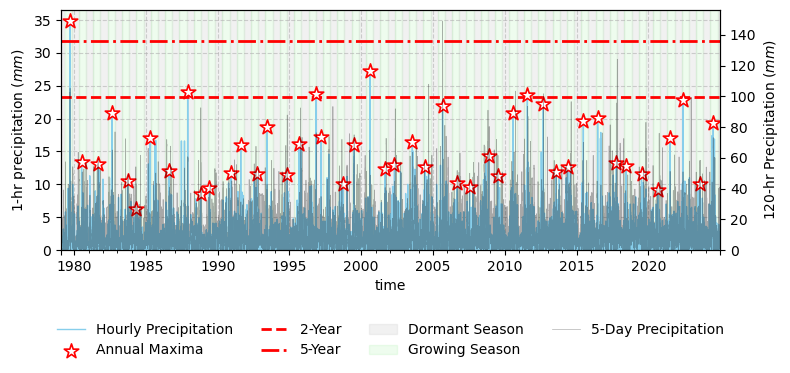

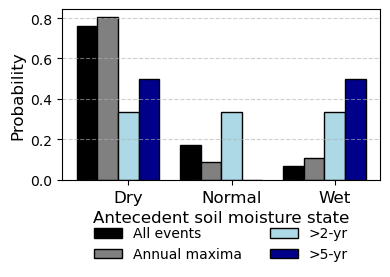

In [17]:
thresholds = [0.918, 1.25]  # in inches
lat_nys =  44.1988
lon_nys = -76.0750
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

Loading years: 100%|██████████| 46/46 [00:34<00:00,  1.33it/s]


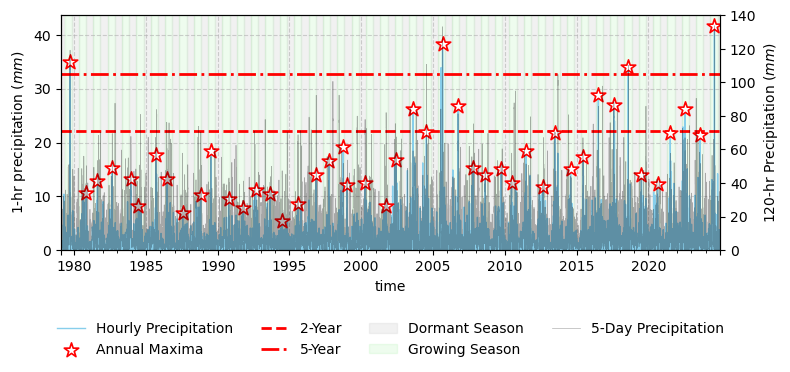

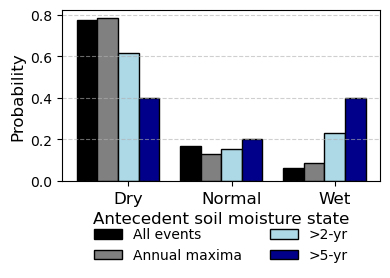

In [18]:
thresholds = [0.872, 1.29]  # in inches
lat_nys =  44.6070
lon_nys = -75.0203
analyze_aorc_amc_plots(lat_nys, lon_nys, thresholds)

# Several locations

In [19]:
def get_amc_distribution(lat, lon, thresholds_in, start_year=1979, end_year=2024):
    base_url = 's3://noaa-nws-aorc-v1-1-1km'
    var = 'APCP_surface'
    thresholds_mm = [t * 25.4 for t in thresholds_in]
    years = range(start_year, end_year + 1)

    all_ts = []
    for year in tqdm(years, desc=f"Loading {lat},{lon}"):
        url = f"{base_url}/{year}.zarr/"
        ds = xr.open_zarr(url, consolidated=True, storage_options={"anon": True})
        precip_ts = ds[var].sel(latitude=lat, longitude=lon, method='nearest')
        all_ts.append(precip_ts.to_series())

    hourly_series = pd.concat(all_ts)
    antecedent_5day = hourly_series.rolling(window=120).sum().shift(1)

    def classify_amc(ts, rain_5d):
        m = ts.month
        if pd.isna(rain_5d):
            return None
        if 5 <= m <= 10:
            if rain_5d < 1.4*25.4: return 'Dry'
            elif rain_5d <= 2.1*25.4: return 'Normal'
            else: return 'Wet'
        else:
            if rain_5d < 0.5*25.4: return 'Dry'
            elif rain_5d <= 1.1*25.4: return 'Normal'
            else: return 'Wet'

    amc = pd.Series([classify_amc(ts, rain) for ts, rain in antecedent_5day.items()], index=antecedent_5day.index)
    df = pd.DataFrame({
        'hourly_rain_mm': hourly_series,
        'antecedent_5day_mm': antecedent_5day,
        'AMC': amc
    })

    amc_order = ['Dry', 'Normal', 'Wet']

    # --- Compute Counts ---
    counts_all = df['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)

    annual_max_idx = hourly_series.resample('YE').apply(lambda x: x.idxmax()).dropna()
    amc_annual_max = df.loc[annual_max_idx, 'AMC']
    counts_annual = amc_annual_max.value_counts(normalize=True).reindex(amc_order).fillna(0)

    threshold_counts = []
    for t_mm in thresholds_mm:
        subset = df[df['hourly_rain_mm'] > t_mm]
        counts = subset['AMC'].value_counts(normalize=True).reindex(amc_order).fillna(0)
        threshold_counts.append(counts)

    return counts_all, counts_annual, threshold_counts


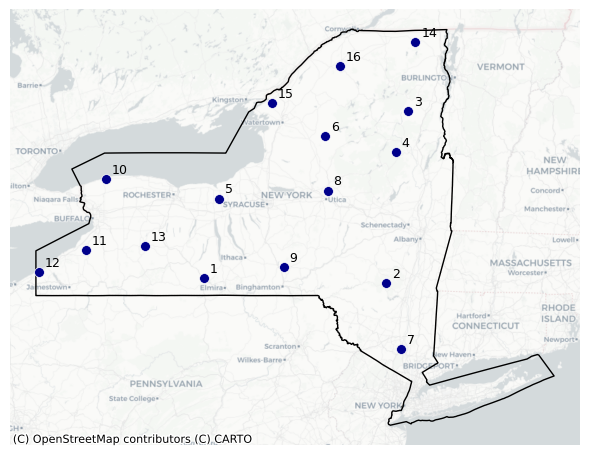

In [35]:
# Define location data
locations = [
    {"lat": 42.2, "lon": -77.14, "thresholds": [0.709, 0.960]},
    {"lat": 42.1445, "lon": -74.2952, "thresholds": [0.844, 1.15]},
    {"lat": 44.1009, "lon": -73.9436, "thresholds": [0.728, 0.988]},
    {"lat": 43.6392, "lon": -74.1414, "thresholds": [0.896, 1.20]},
    {"lat": 43.1145, "lon": -76.8989, "thresholds": [0.874, 1.19]},
    {"lat": 43.8241, "lon": -75.2400, "thresholds": [0.895, 1.21]},
    {"lat": 41.3777, "lon": -74.0535, "thresholds": [1.16, 1.52]},
    {"lat": 43.2060, "lon": -75.2071, "thresholds": [0.954, 1.24]},
    {"lat": 42.3269, "lon": -75.8882, "thresholds": [0.915, 1.27]},
    {"lat": 43.3340, "lon": -78.6677, "thresholds": [0.845, 1.18]},
    {"lat": 42.5297, "lon": -78.9864, "thresholds": [0.929, 1.25]},
    {"lat": 42.2701, "lon": -79.7114, "thresholds": [1.00, 1.32]},
    {"lat": 42.5701, "lon": -78.0635, "thresholds": [0.852, 1.16]},
    {"lat": 44.8723, "lon": -73.8338, "thresholds": [0.883, 1.26]},
    {"lat": 44.1988, "lon": -76.0750, "thresholds": [0.918, 1.25]},
    {"lat": 44.6070, "lon": -75.0203, "thresholds": [0.872, 1.29]},
]

# Create GeoDataFrame
df = pd.DataFrame(locations)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df["lon"], df["lat"]), crs="EPSG:4326")
gdf_web = gdf.to_crs(epsg=3857)

# Load and reproject state boundary
base_dir = r'D:\culvert repo\data\initial layers'
state_shapefile_path = rf"{base_dir}\state_5070.shp"
state = gpd.read_file(state_shapefile_path).to_crs(epsg=3857)

# Plot
fig, ax = plt.subplots(figsize=(6, 6))

# Plot state boundary
state.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1, zorder=1)

gdf_web.plot(ax=ax, color='darkblue', edgecolor='white', linewidth=0.5, markersize=50, zorder=2)

# Label points
for i, row in gdf_web.iterrows():
    ax.annotate(f"{i+1}", (row.geometry.x + 10000, row.geometry.y + 10000), fontsize=9)

# Add basemap using a valid provider
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
ax.set_axis_off()
plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\allsamples_map_amc.png", dpi=300, bbox_inches='tight')
plt.show()


In [21]:
# Define locations and thresholds
# Initialize totals
total_all = total_annual = pd.Series(0.0, index=['Dry', 'Normal', 'Wet'])
total_thresholds = [pd.Series(0.0, index=['Dry', 'Normal', 'Wet']) for _ in range(2)]

# Aggregate across locations
for loc in locations:
    counts_all, counts_annual, threshold_counts = get_amc_distribution(loc["lat"], loc["lon"], loc["thresholds"])
    total_all += counts_all
    total_annual += counts_annual
    for i in range(len(threshold_counts)):
        total_thresholds[i] += threshold_counts[i]

# Average across all locations
n = len(locations)
avg_all = total_all / total_all.sum()
avg_annual = total_annual / total_annual.sum()
avg_thresholds = [tc / tc.sum() for tc in total_thresholds]

Loading 44.607,-75.0203: 100%|██████████| 46/46 [00:32<00:00,  1.41it/s]


In [22]:
print(avg_all.sum())  # should be close to 1.0

1.0


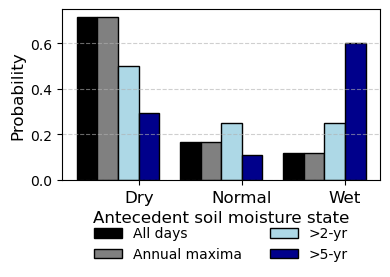

In [26]:
# Plot the merged AMC distribution
plt.figure(figsize=(4, 3))
bar_width = 0.2
amc_order = ['Dry', 'Normal', 'Wet']

# Plot All Days
offset = -1 * bar_width
plt.bar(
    [x + offset for x in range(len(amc_order))],
    avg_all.values,
    width=bar_width,
    label='All days',
    edgecolor='black',
    color='black'
)

# Plot Annual Maxima
plt.bar(
    [x for x in range(len(amc_order))],
    avg_annual.values,
    width=bar_width,
    label='Annual maxima',
    edgecolor='black',
    color='gray'
)

# Plot Thresholds
threshold_labels = ['>2-yr', '>5-yr']
threshold_colors = ['lightblue', 'darkblue']
for i, counts in enumerate(avg_thresholds):
    offset = (i + 1) * bar_width
    plt.bar(
        [x + offset for x in range(len(amc_order))],
        counts.values,
        width=bar_width,
        label=threshold_labels[i],
        color=threshold_colors[i],
        edgecolor='black'
    )

# Formatting
total_bars = len(avg_thresholds) + 2
midpoints = [x + bar_width * (total_bars - 1) / 2 for x in range(len(amc_order))]
plt.xticks(midpoints, amc_order, fontsize=12)
plt.ylabel("Probability", fontsize=12)
plt.xlabel("Antecedent soil moisture state", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.2), frameon=False)
plt.tight_layout()
plt.savefig(fr"D:\culvert repo\Results\Figures\allsamples_AMC_state_prob.png", dpi=300, bbox_inches='tight')

plt.show()


In [24]:
# Date and time
now = datetime.datetime.now()
print(f"Date and time: {now}")

Date and time: 2025-07-26 12:53:46.522235


In [25]:
%load_ext watermark
# Print the Python version and some dependencies
%watermark -v -m -p numpy,pandas,geopandas,matplotlib,os,rasterio,tqdm,contextily,shapely

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.20.0

numpy     : 2.0.2
pandas    : 2.2.2
geopandas : 1.0.1
matplotlib: 3.8.4
os        : unknown
rasterio  : 1.4.3
tqdm      : 4.66.5
contextily: 1.6.1
shapely   : 2.0.7

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
CPU cores   : 24
Architecture: 64bit

